In [134]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.feature_selection import SequentialFeatureSelector

In [135]:
def print_classification_report(y, y_pred):
    matriz_confusion = confusion_matrix(y,y_pred)
    matriz_confusion_df = pd.DataFrame(matriz_confusion, index=['False','True'], columns=['False','True'])
    print(matriz_confusion_df)
    accuracy= accuracy_score(y, y_pred)
    print(" ")
    print(f"Accuracy: {accuracy}")
    precision = precision_score(y, y_pred)
    print(f"Precision: {precision}")
    recall = recall_score(y, y_pred)
    print(f"Recall: {recall}")
    auc = roc_auc_score(y, y_pred)
    print(f"Area bajo la curva: {auc}")

# LECTURA DEL FICHERO

In [136]:
diabetes_df = pd.read_csv('diabetes.csv')

# ANÁLISIS DE DATOS

## INFO
Primero realizamos un info de los datos que nos da información sobre las columnas que tiene el dataset, el tipo de datos que tienen y el número de valores no nulos.

In [137]:
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


## HEAD 

De esta manera se puede contrastar que los tipos de datos que nos muestra info son correctos, además de hacernos una primera idea de las magnitudes que tiene cada variable.

In [138]:
diabetes_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## DESCRIBE

Obtendremos información estadística de cada una de las variables continuas. Dependiendo de las distribuciones de los datos y el modelos a aplicar nos puede dar una idea de la necesidad de escalar las variables y cómo hacerlo



In [139]:
diabetes_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## HIST

Vamos a mostrar la distribución de cada variable con un histograma. Para la variable objetivo nos puede dar una idea de nivel de balanceo que tiene

array([[<Axes: title={'center': 'Pregnancies'}>,
        <Axes: title={'center': 'Glucose'}>,
        <Axes: title={'center': 'BloodPressure'}>],
       [<Axes: title={'center': 'SkinThickness'}>,
        <Axes: title={'center': 'Insulin'}>,
        <Axes: title={'center': 'BMI'}>],
       [<Axes: title={'center': 'DiabetesPedigreeFunction'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Outcome'}>]], dtype=object)

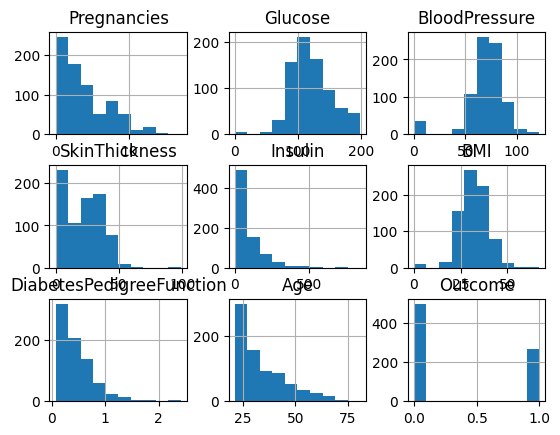

In [140]:
diabetes_df.hist()

## CORRELACIONES

Vamos a mostrar el nivel de correlaciones de cada variable con la variable objetivo. Primero de manera numérica y luego con un boxplot de cada variable agrupando por la cariable objetivo. Es importante revisar las correlaciones de manera gráfica ya que los datos numéricos pueden verse impactados por valores atípicos.

In [141]:
diabetes_df.corr()['Outcome']

Pregnancies                 0.221898
Glucose                     0.466581
BloodPressure               0.065068
SkinThickness               0.074752
Insulin                     0.130548
BMI                         0.292695
DiabetesPedigreeFunction    0.173844
Age                         0.238356
Outcome                     1.000000
Name: Outcome, dtype: float64

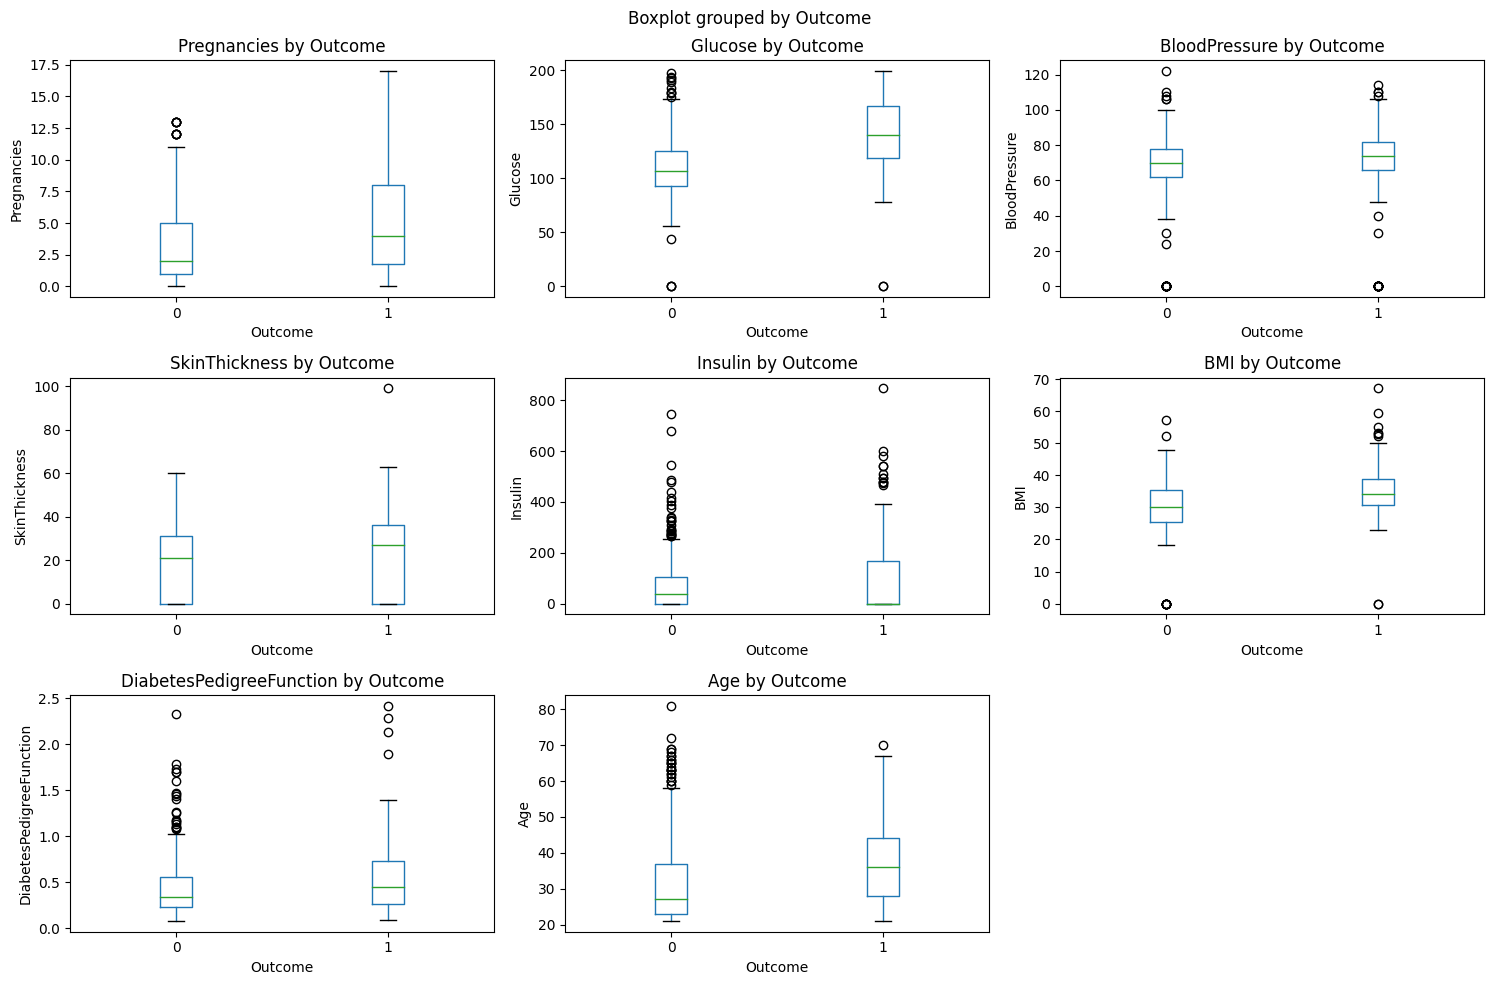

In [142]:
# Excluye la columna 'Outcome' para crear gráficos de caja para las demás
columns = diabetes_df.columns[:-1]
outcome = diabetes_df['Outcome']

# Configurar el número de filas y columnas de subplots
n_rows = 3
n_cols = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))

# Aplanar el arreglo de ejes para iterar fácilmente (si es necesario)
axes = axes.flatten()

# Crear gráficos de caja por cada columna
for i, col in enumerate(columns):
    ax = axes[i]
    diabetes_df.boxplot(column=[col], by='Outcome', ax=ax, grid=False)
    ax.set_title(f'{col} by Outcome')
    ax.set_xlabel('Outcome')
    ax.set_ylabel(col)

# Quitar gráficos sobrantes si hay menos columnas que subplots
for j in range(len(columns), len(axes)):
    fig.delaxes(axes[j])

# Ajustar el diseño
plt.tight_layout()
plt.show()

# SEPARACIÓN DE VARIABLES INDEPENDIENTES Y VARIABLE DEPENDIENTE

In [143]:
X = diabetes_df.iloc[:,:-1]
y = diabetes_df['Outcome']

# MODELO

## MODELO BENCHMARK

Realizamos un primer modelo que vamos a utilizar como benchmark para asegurarnos que todos los cambios que hagamos a los datos o al modelo mejoren los resultados.

In [144]:
knn = KNeighborsClassifier(n_neighbors=5)
y_pred = cross_val_predict(knn, X, y, cv=5)
print_classification_report(y,y_pred)

       False  True
False    414    86
True     126   142
 
Accuracy: 0.7239583333333334
Precision: 0.6228070175438597
Recall: 0.5298507462686567
Area bajo la curva: 0.6789253731343284


## BALANCEO DE LA SALIDA

Balanceamos la salida, en este caso knn no cuenta con un balanceo de carga, pero sí cuenta con el parámetro weights="distance" que hace que los valores más cercanos influyan más lo que puede mitigar el balanceo. El resultado mejora porque tiene un mayor accuracy y auc, aunque igual recall, pero lo hace de manera muy leve. 

In [145]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
y_pred = cross_val_predict(knn, X, y, cv=5)
print_classification_report(y,y_pred)

       False  True
False    416    84
True     126   142
 
Accuracy: 0.7265625
Precision: 0.6283185840707964
Recall: 0.5298507462686567
Area bajo la curva: 0.6809253731343283


Vamos a probar balanceando los datos haciendo "oversampling". Hay que recordar que el "oversampling" aumenta la cantidad de ejemplos de la clase minoritaria duplicando las instancias existentes o generando nuevas instancias sintéticas. Esto ayuda a equilibrar el conjunto de datos y mejorar el rendimiento del modelo, especialmente en la predicción de la clase minoritaria. En este caso para mejorar el recall necesitamos minimizar los false negative que realmente son puntos de la clase minoritaria. Para eso vamos a utilizar SMOTE (Synthetic Minority Over-sampling Technique). SMOTE crea nuevos ejemplos de la clase minoritaria interpolando entre los puntos de datos existentes de la clase minoritaria,  . Se puede observar en los resultados que al aplicar SMOTE el resultado mejora notablementte. El recall mejora de 0.52 a 0.892 y también mejoran tanto el accuracy como el área bajo la curva.



In [146]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
y_pred = cross_val_predict(knn, X_resampled, y_resampled, cv=5)
print_classification_report(y_resampled,y_pred)

       False  True
False    334   166
True      54   446
 
Accuracy: 0.78
Precision: 0.7287581699346405
Recall: 0.892
Area bajo la curva: 0.7799999999999999


## NORMALIZACIÓN DE VARIABLES

## Z-SCORE

Se aplica standardscaler, que corresponde a la normalización z_score. Esta normalización mantiene la distribución de los datos, dejando los datos con media 0 y desviación estandar 1. Es especialmente recomendable para variables con distribución normal. En este problema en el que las distancias son especialmente sensibles a las magnitudes se recomienda estandarizar todas las variables siguiendo el mismo método, con lo que independientemente de si la distrución es normal o no normalizacmos las variables con z-score.

Al realizar la normalización z-score podemos observar que los resultados mejoran tanto en accuracy y auc como en recall.

In [147]:
standard_cols = ['Glucose', 'BloodPressure', 'BMI', 'SkinThickness', 'Pregnancies','Insulin','DiabetesPedigreeFunction','Age']
X_resampled_norm_standard = X_resampled.copy()
X_resampled_norm_standard[standard_cols] = StandardScaler().fit_transform(X_resampled_norm_standard[standard_cols])
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
y_pred = cross_val_predict(knn, X_resampled_norm_standard, y_resampled, cv=5)
print_classification_report(y_resampled,y_pred)

       False  True
False    363   137
True      50   450
 
Accuracy: 0.813
Precision: 0.7666098807495741
Recall: 0.9
Area bajo la curva: 0.813


In [182]:
diabetes_df_standard = X_resampled_norm_standard.copy()
diabetes_df_standard['Outcome'] = y_resampled
diabetes_df_standard['Outcome_predict'] = y_pred

## MIN MAX SCALLER

Escalamos todas las variables esta vez utilizando min max scaller. Cabe destacar que esta distribución escala los valores entre 0 y 1. Suele mantener la distribución de los datos salvo que el máximo o el mínimo sean valores muy extremos, que no es el caso. 

Podemos observar que al aplicar min max scaller a todas las variables se mejoran los resultados frente a los datos balanceados, pero no frente a los resultados con normalización z-score.

In [151]:
min_max_cols = ['Glucose', 'BloodPressure', 'BMI', 'SkinThickness', 'Pregnancies','Insulin','DiabetesPedigreeFunction','Age']
X_resampled_norm_min_max = X_resampled.copy()
X_resampled_norm_min_max[standard_cols] = MinMaxScaler().fit_transform(X_resampled_norm_min_max[min_max_cols])
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
y_pred = cross_val_predict(knn, X_resampled_norm_min_max, y_resampled, cv=5)
print_classification_report(y_resampled,y_pred)

       False  True
False    352   148
True      59   441
 
Accuracy: 0.793
Precision: 0.7487266553480475
Recall: 0.882
Area bajo la curva: 0.793


In [183]:
diabetes_df_min_max = X_resampled_norm_min_max
diabetes_df_min_max['Outcome'] = y_resampled

# HAYAMOS EL NÚMERO DE VECINOS ÓPTIMO POR EL MÉTODO DEL CODO
Para ver el número de k óptimo se aplica el método del codo. Hallamos los resultados para diferentes k, en este caso de 1 a 21 y nos quedamos con el k que forme un codo en la gráfica en caso de que la gráfica tenga una asíntota o si no el mínimo. En este caso este caso como estábamos quedando con el mejor recall, lo que hacemos es la inversa del recall para hallar ese mínimo. 

Observamos que para k = 5 obtenemos el resultado mínimo. 

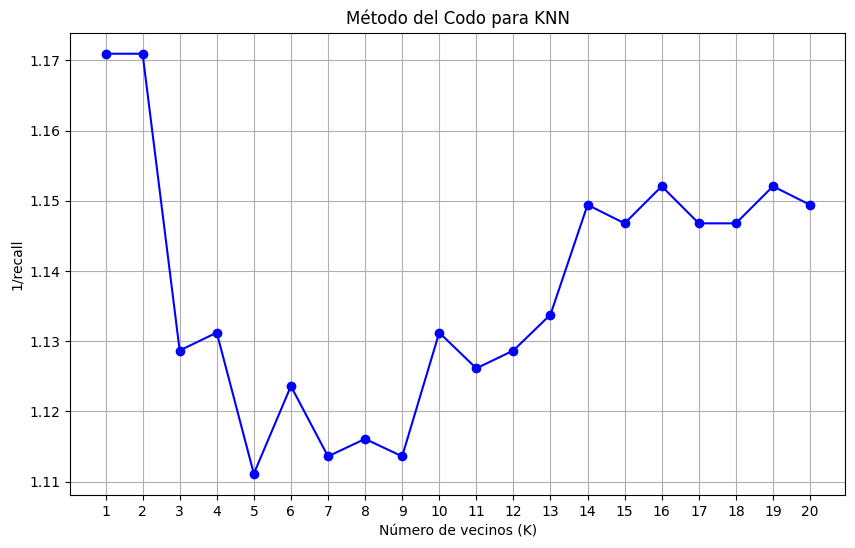

In [159]:
# Evaluar diferentes valores de K
error_rate = []
for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    y_pred = cross_val_predict(knn, X_resampled_norm_standard, y_resampled, cv=5)
    error_rate.append(1/recall_score(y_resampled, y_pred))

# Graficar el método del codo
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), error_rate, marker='o', color='b')
plt.title('Método del Codo para KNN')
plt.xlabel('Número de vecinos (K)')
plt.ylabel('1/recall')
plt.xticks(range(1, 21))
plt.grid(True)
plt.show()

# SELECCIÓN DE VARIABLES

## FORWARD FEATURE SELECTION

In [160]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
ffs = SequentialFeatureSelector(knn, direction='forward', scoring="recall", cv=5, tol=0.000001)
ffs.fit(X_resampled_norm_standard, y_resampled)
ffs.get_feature_names_out()

array(['Glucose', 'BloodPressure', 'Insulin', 'BMI', 'Age'], dtype=object)

## BACKWARD FEATURE SELECTION

In [161]:
selected_features = ['Glucose', 'BloodPressure', 'Insulin', 'BMI', 'Age']
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
y_pred = cross_val_predict(knn, X_resampled_norm_standard[selected_features], y_resampled, cv=5)
print_classification_report(y_resampled,y_pred)

       False  True
False    352   148
True      52   448
 
Accuracy: 0.8
Precision: 0.7516778523489933
Recall: 0.896
Area bajo la curva: 0.7999999999999998


In [170]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
ffs = SequentialFeatureSelector(knn, direction='backward', scoring="recall", cv=5, tol=0.000001)
ffs.fit(X_resampled_norm_standard, y_resampled)
ffs.get_feature_names_out()

array(['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI',
       'DiabetesPedigreeFunction', 'Age'], dtype=object)

In [171]:
selected_features = ['Glucose', 'BloodPressure','SkinThickness','DiabetesPedigreeFunction', 'Insulin', 'BMI', 'Age']
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
y_pred = cross_val_predict(knn, X_resampled_norm_standard[selected_features], y_resampled, cv=5)
print_classification_report(y_resampled,y_pred)

       False  True
False    365   135
True      48   452
 
Accuracy: 0.817
Precision: 0.7700170357751278
Recall: 0.904
Area bajo la curva: 0.817


## FORWARD FEATURE SELECTION PROPIO EN EL QUE IMPRIMIMOS POR ORDEN DE IMPORTANCIA LAS VARIABLES SELECCIONADAS

In [162]:
# Forward Feature Selection
remaining_features = list(X_resampled_norm_standard.columns)  # Todas las características disponibles
selected_features = []
best_recall = 0

while len(remaining_features)!=0:
    knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
    recall_scores = []  # Lista para almacenar los recall scores de cada característica candidata
    
    # Probar cada característica restante
    for feature in remaining_features:
        # Seleccionar las características actuales + la nueva
        features_to_try = selected_features + [feature]
        X_subset = X_resampled_norm_standard[features_to_try]
        
        # Entrenar el modelo con el subconjunto de características
        y_pred = cross_val_predict(knn, X_subset, y_resampled, cv=5)
        recall = recall_score(y_resampled, y_pred)
        # Guardar el recall de esta combinación
        recall_scores.append((feature, recall))
    
    # Ordenar por el mejor recall y elegir la característica con mejor rendimiento
    best_feature, best_feature_recall = max(recall_scores, key=lambda x: x[1])
    
    # Si la mejora en recall es positiva, seleccionamos la característica
    if best_feature_recall > best_recall:
        selected_features.append(best_feature)
        remaining_features.remove(best_feature)
        best_recall = best_feature_recall
        best_features = selected_features.copy()  # Actualizar el mejor conjunto de características
        print(f"Seleccionando característica {best_feature} con recall = {best_recall:.4f}")
    else:
        # Si no mejora, terminamos
        break

Seleccionando característica Glucose con recall = 0.5700
Seleccionando característica BMI con recall = 0.7600
Seleccionando característica Age con recall = 0.8240
Seleccionando característica BloodPressure con recall = 0.8780
Seleccionando característica Insulin con recall = 0.8960


# PROBLEMA RESUELTO DE LA CLASE DEL 08/01/2025

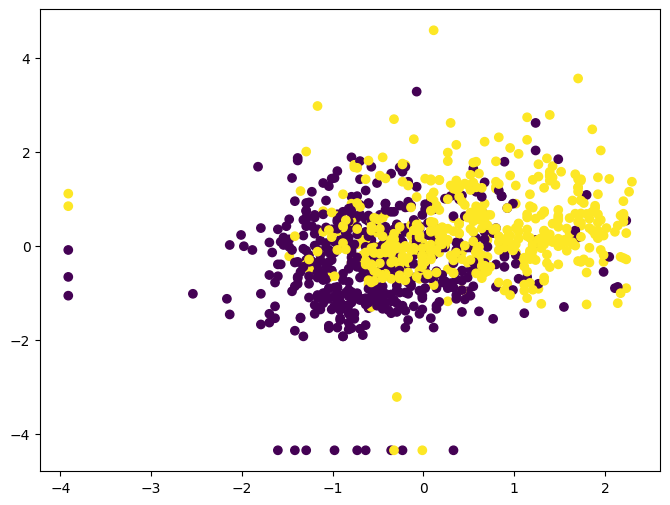

In [184]:
# Crear el scatter plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_resampled_norm_standard['Glucose'], X_resampled_norm_standard['BMI'], c=y_resampled, cmap='viridis')

In [165]:
X = diabetes_df_standard[['Glucose','BMI']]
y = diabetes_df_standard['Outcome']

clf = LogisticRegression(class_weight='balanced',solver='liblinear')
y_pred = cross_val_predict(clf, X, y, cv=5)
print_classification_report(y,y_pred)
logistic_df = X
logistic_df['Outcome']=y
logistic_df['Outcome_pred']=y_pred

       False  True
False    378   122
True     152   348
 
Accuracy: 0.726
Precision: 0.7404255319148936
Recall: 0.696
Area bajo la curva: 0.726


/var/folders/95/w9lhhbrs68qch3dk3k2qyw6c0000gn/T/ipykernel_3413/459830825.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  logistic_df['Outcome']=y
/var/folders/95/w9lhhbrs68qch3dk3k2qyw6c0000gn/T/ipykernel_3413/459830825.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  logistic_df['Outcome_pred']=y_pred


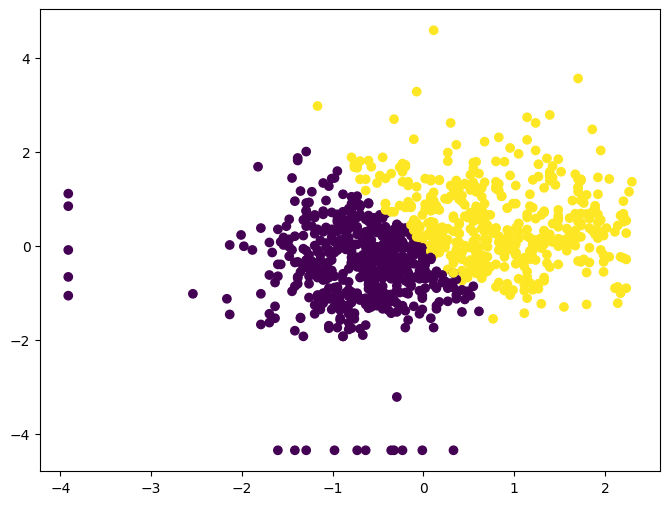

In [167]:
# Crear el scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(logistic_df['Glucose'], logistic_df['BMI'], c=logistic_df['Outcome_pred'], cmap='viridis')

In [168]:
X = diabetes_df_standard[['Glucose','BMI']]
y = diabetes_df_standard['Outcome']

knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
y_pred = cross_val_predict(knn, X, y, cv=5)
print_classification_report(y,y_pred)
knn_df = X
knn_df['Outcome']=y
knn_df['Outcome_pred']=y_pred

       False  True
False    349   151
True     120   380
 
Accuracy: 0.729
Precision: 0.7156308851224106
Recall: 0.76
Area bajo la curva: 0.729


/var/folders/95/w9lhhbrs68qch3dk3k2qyw6c0000gn/T/ipykernel_3413/2030692239.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knn_df['Outcome']=y
/var/folders/95/w9lhhbrs68qch3dk3k2qyw6c0000gn/T/ipykernel_3413/2030692239.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knn_df['Outcome_pred']=y_pred


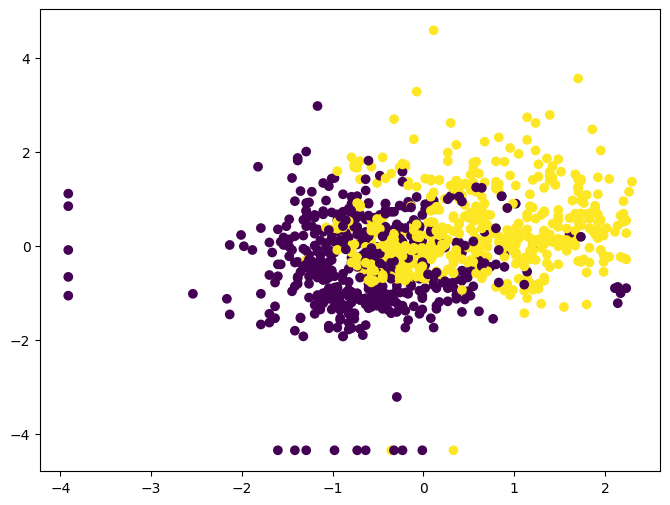

In [169]:
# Crear el scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(knn_df['Glucose'], knn_df['BMI'], c=knn_df['Outcome_pred'], cmap='viridis')